[*********************100%%**********************]  1 of 1 completed
/var/folders/ym/b4m57f6j42b3lpggtjxmwwkm0000gn/T/ipykernel_59351/4255753761.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Log_Return_Norm"] = (data["Log_Return"] - data["Log_Return"].mean()) / data["Log_Return"].std()
/var/folders/ym/b4m57f6j42b3lpggtjxmwwkm0000gn/T/ipykernel_59351/4255753761.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Volatility_Norm"] = (data["Volatility"] - data["Volatility"].mean()) / data["

Epoch 1, Loss: 0.0108
Epoch 2, Loss: 0.0054
Epoch 3, Loss: 0.0054
Epoch 4, Loss: 0.0054
Epoch 5, Loss: 0.0055
Epoch 6, Loss: 0.0054
Epoch 7, Loss: 0.0053
Epoch 8, Loss: 0.0053
Epoch 9, Loss: 0.0052
Epoch 10, Loss: 0.0053
Epoch 11, Loss: 0.0053
Epoch 12, Loss: 0.0054
Epoch 13, Loss: 0.0053
Epoch 14, Loss: 0.0054
Epoch 15, Loss: 0.0053
Epoch 16, Loss: 0.0053
Epoch 17, Loss: 0.0053
Epoch 18, Loss: 0.0053
Epoch 19, Loss: 0.0053
Epoch 20, Loss: 0.0054
Epoch 21, Loss: 0.0054
Epoch 22, Loss: 0.0053
Epoch 23, Loss: 0.0053
Epoch 24, Loss: 0.0053
Epoch 25, Loss: 0.0053
Epoch 26, Loss: 0.0052
Epoch 27, Loss: 0.0054
Epoch 28, Loss: 0.0053
Epoch 29, Loss: 0.0053
Epoch 30, Loss: 0.0053
Epoch 31, Loss: 0.0052
Epoch 32, Loss: 0.0051
Epoch 33, Loss: 0.0052
Epoch 34, Loss: 0.0052
Epoch 35, Loss: 0.0050
Epoch 36, Loss: 0.0051
Epoch 37, Loss: 0.0051
Epoch 38, Loss: 0.0051
Epoch 39, Loss: 0.0052
Epoch 40, Loss: 0.0050
Epoch 41, Loss: 0.0050
Epoch 42, Loss: 0.0050
Epoch 43, Loss: 0.0051
Epoch 44, Loss: 0.00

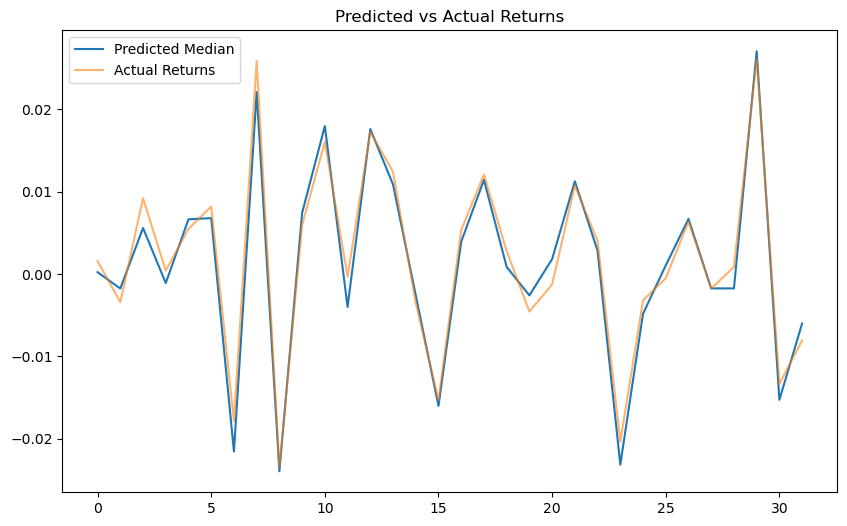

In [ ]:

import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

def fetch_and_preprocess_data(ticker="SPY", start_date="2020-01-01", end_date="2023-01-01"):
    
    data = yf.download(ticker, start=start_date, end=end_date)
    
    data["Log_Return"] = np.log(data["Close"] / data["Close"].shift(1))
    data["Volatility"] = data["Log_Return"].rolling(window=10).std()
    
    data = data.dropna()
    
    data["Log_Return_Norm"] = (data["Log_Return"] - data["Log_Return"].mean()) / data["Log_Return"].std()
    data["Volatility_Norm"] = (data["Volatility"] - data["Volatility"].mean()) / data["Volatility"].std()
    
    return data

class AssetDataset(Dataset):
    def __init__(self, X, Z, y):
        self.X = X
        self.Z = Z
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Z[idx], self.y[idx]

class AssetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_quantiles, dropout=0.1): #dropout from paper (.1)
        super(AssetLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_quantiles)

    def forward(self, x):
        out, _ = self.lstm(x) #output
        out = self.fc(out[:, -1, :]) #we only want the last step so
        return out

class MarketScaler(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super(MarketScaler, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.activation = nn.Sigmoid()  
        out, _ = self.lstm(z)
        out = self.fc(out[:, -1, :])  
        scaling_factor = self.activation(out)  
        return scaling_factor


class QuantilePredictionModel(nn.Module):
    def __init__(self, asset_input_size, market_input_size, hidden_size, num_layers, num_quantiles, dropout=0.2):
        super(QuantilePredictionModel, self).__init__()
        self.asset_model = AssetLSTM(asset_input_size, hidden_size, num_layers, num_quantiles, dropout)
        self.market_scaler = MarketScaler(market_input_size, hidden_size, num_layers, dropout)

    def forward(self, x, z):
        quantiles = self.asset_model(x)
        scaling_factor = self.market_scaler(z)
        scaled_quantiles = quantiles * scaling_factor
        return scaled_quantiles

def quantile_loss(predictions, targets, quantiles):
    errors = targets - predictions
    loss = torch.maximum(quantiles * errors, (quantiles - 1) * errors).mean()
    return loss

def train_model_with_graph():
    data = fetch_and_preprocess_data()
    
    seq_len = 30
    X = []
    Z = []
    y = []
    for i in range(len(data) - seq_len):
        X.append(data.iloc[i:i+seq_len][["Log_Return_Norm"]].values)
        Z.append(data.iloc[i:i+seq_len][["Volatility_Norm"]].values)
        y.append(data.iloc[i+seq_len]["Log_Return"])
    
    X = torch.tensor(X, dtype=torch.float32)
    Z = torch.tensor(Z, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    
    dataset = AssetDataset(X, Z, y)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    num_features = 1
    num_quantiles = 1
    model = QuantilePredictionModel(asset_input_size=num_features, market_input_size=num_features,
                                     hidden_size=64, num_layers=2, num_quantiles=num_quantiles)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    quantiles = torch.tensor([0.5]).reshape(1, -1)  # Median quantile
    
    
    for epoch in range(500):
        total_loss = 0
        for batch_X, batch_Z, batch_y in dataloader:
            optimizer.zero_grad()
            predictions = model(batch_X, batch_Z)
            loss = quantile_loss(predictions, batch_y, quantiles)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader):.4f}")
    
    test_X, test_Z, test_y = next(iter(dataloader))
    predictions = model(test_X, test_Z).detach().numpy()
    test_y = test_y.numpy()

    plt.figure(figsize=(10, 6))
    plt.plot(predictions, label="Predicted Median")
    plt.plot(test_y, label="Actual Returns", alpha=0.6)
    plt.title("Predicted vs Actual Returns")
    plt.legend()
    plt.show()

train_model_with_graph()


[*********************100%%**********************]  1 of 1 completed
/var/folders/ym/b4m57f6j42b3lpggtjxmwwkm0000gn/T/ipykernel_59351/1229264272.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Log_Return_Norm"] = (data["Log_Return"] - data["Log_Return"].mean()) / data["Log_Return"].std()
/var/folders/ym/b4m57f6j42b3lpggtjxmwwkm0000gn/T/ipykernel_59351/1229264272.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Volatility_Norm"] = (data["Volatility"] - data["Volatility"].mean()) / data["

Epoch 1, Loss: 0.0093
Epoch 2, Loss: 0.0089
Epoch 3, Loss: 0.0089
Epoch 4, Loss: 0.0088
Epoch 5, Loss: 0.0088
Epoch 6, Loss: 0.0088
Epoch 7, Loss: 0.0088
Epoch 8, Loss: 0.0088
Epoch 9, Loss: 0.0088
Epoch 10, Loss: 0.0088
Epoch 11, Loss: 0.0088
Epoch 12, Loss: 0.0087
Epoch 13, Loss: 0.0087
Epoch 14, Loss: 0.0088
Epoch 15, Loss: 0.0087
Epoch 16, Loss: 0.0087
Epoch 17, Loss: 0.0087
Epoch 18, Loss: 0.0087
Epoch 19, Loss: 0.0087
Epoch 20, Loss: 0.0087
Epoch 21, Loss: 0.0087
Epoch 22, Loss: 0.0087
Epoch 23, Loss: 0.0087
Epoch 24, Loss: 0.0087
Epoch 25, Loss: 0.0087
Epoch 26, Loss: 0.0086
Epoch 27, Loss: 0.0086
Epoch 28, Loss: 0.0086
Epoch 29, Loss: 0.0086
Epoch 30, Loss: 0.0086
Epoch 31, Loss: 0.0086
Epoch 32, Loss: 0.0086
Epoch 33, Loss: 0.0086
Epoch 34, Loss: 0.0086
Epoch 35, Loss: 0.0086
Epoch 36, Loss: 0.0085
Epoch 37, Loss: 0.0086
Epoch 38, Loss: 0.0085
Epoch 39, Loss: 0.0085
Epoch 40, Loss: 0.0085
Epoch 41, Loss: 0.0085
Epoch 42, Loss: 0.0085
Epoch 43, Loss: 0.0085
Epoch 44, Loss: 0.00

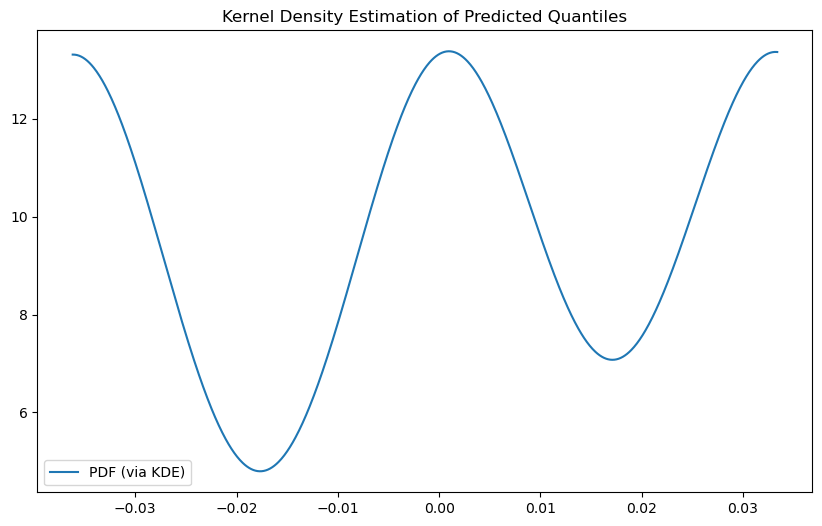

In [ ]:
from sklearn.neighbors import KernelDensity
import numpy as np
import matplotlib.pyplot as plt

def fetch_and_preprocess_data(ticker="BTC-USD", start_date="2020-01-01", end_date="2023-01-01"):
    
    data = yf.download(ticker, start=start_date, end=end_date)
    
    data["Log_Return"] = np.log(data["Close"] / data["Close"].shift(1))
    data["Volatility"] = data["Log_Return"].rolling(window=10).std()
    
    data = data.dropna()
    
    data["Log_Return_Norm"] = (data["Log_Return"] - data["Log_Return"].mean()) / data["Log_Return"].std()
    data["Volatility_Norm"] = (data["Volatility"] - data["Volatility"].mean()) / data["Volatility"].std()
    
    return data

# Updated QuantilePredictionModel for multiple quantiles
class QuantilePredictionModel(nn.Module):
    def __init__(self, asset_input_size, market_input_size, hidden_size, num_layers, num_quantiles, dropout=0.2):
        super(QuantilePredictionModel, self).__init__()
        self.asset_model = AssetLSTM(asset_input_size, hidden_size, num_layers, num_quantiles, dropout)
        self.market_scaler = MarketScaler(market_input_size, hidden_size, num_layers, dropout)

    def forward(self, x, z):
        quantiles = self.asset_model(x)
        scaling_factor = self.market_scaler(z)
        scaled_quantiles = quantiles * scaling_factor
        return scaled_quantiles

# KDE Function
def apply_kde(quantiles, bandwidth=0.01):
    """
    Convert quantile predictions to a smooth PDF using Kernel Density Estimation.
    """
    quantiles = np.array(quantiles).reshape(-1, 1)

    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(quantiles)

    # generate a dense range of values for the PDF
    dense_range = np.linspace(quantiles.min(), quantiles.max(), 1000).reshape(-1, 1)
    log_density = kde.score_samples(dense_range)
    pdf = np.exp(log_density)

    return dense_range, pdf

# training with multiple quantiles
def train_model_with_kde():
    data = fetch_and_preprocess_data()
    
    seq_len = 30
    X = []
    Z = []
    y = []
    for i in range(len(data) - seq_len):
        X.append(data.iloc[i:i+seq_len][["Log_Return_Norm"]].values)
        Z.append(data.iloc[i:i+seq_len][["Volatility_Norm"]].values)
        y.append(data.iloc[i+seq_len]["Log_Return"])
    
    X = torch.tensor(X, dtype=torch.float32)
    Z = torch.tensor(Z, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    
    dataset = AssetDataset(X, Z, y)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    num_features = 1
    num_quantiles = 3  # Predict 0.1, 0.5, and 0.9 quantiles
    model = QuantilePredictionModel(asset_input_size=num_features, market_input_size=num_features,
                                     hidden_size=64, num_layers=2, num_quantiles=num_quantiles)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    quantiles = torch.tensor([[0.1, 0.5, 0.9]])  # Target quantiles
    
    for epoch in range(50):  # Train for fewer epochs for demonstration
        total_loss = 0
        for batch_X, batch_Z, batch_y in dataloader:
            optimizer.zero_grad()
            predictions = model(batch_X, batch_Z)
            loss = quantile_loss(predictions, batch_y, quantiles)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataloader):.4f}")

    # Test KDE on predicted quantiles
    test_X, test_Z, test_y = next(iter(dataloader))
    predicted_quantiles = model(test_X, test_Z).detach().numpy()

    # Apply KDE on one prediction set (for visualization)
    dense_range, pdf = apply_kde(predicted_quantiles[0], bandwidth=0.01)

    # Plot the KDE-generated PDF
    plt.figure(figsize=(10, 6))
    plt.plot(dense_range, pdf, label="PDF (via KDE)")
    plt.title("Kernel Density Estimation of Predicted Quantiles")
    plt.legend()
    plt.show()

train_model_with_kde()